### Clustering Splitpea networks
Cluster the splitpea output and do enrichment analysis on the cluster labels

In [5]:
import networkx as nx
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
from karateclub.dataset import GraphSetReader
from karateclub import FeatherGraph
import os
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from plotnine import *
from sklearn.cluster import SpectralClustering

In [6]:
# read in the splitpea networks
can = 'PAAD'
net_dir = '/output/' + can + '/mean/'
full_nets = []
neg_nets = []
pos_nets = []
sams = []
for fn in os.listdir(net_dir):
    if 'edges.pickle' in fn:
        print(fn)
        sams.append(fn.replace('.edges.pickle', ''))
        g = pickle.load(open(net_dir + fn, 'rb'))

        g_largest_cc = g.subgraph(max(nx.connected_components(g), key=len)).copy()    
        g_largest_cc_neg = g_largest_cc.copy()
        g_largest_cc_pos = g_largest_cc.copy()
        
        for gi, gj in g_largest_cc.edges():
            if g_largest_cc[gi][gj]['chaos']:
                g_largest_cc_neg.remove_edge(gi, gj)
                g_largest_cc_pos.remove_edge(gi, gj)
                continue

            if g_largest_cc_pos[gi][gj]['weight'] <= 0:
                g_largest_cc_pos.remove_edge(gi, gj)
                g_largest_cc_neg[gi][gj]['weight'] = - g_largest_cc_neg[gi][gj]['weight']
            else:
                g_largest_cc_neg.remove_edge(gi, gj)
        
        # pos and neg may not be fully connected anymore
        g_largest_cc_neg = g_largest_cc_neg.subgraph(max(nx.connected_components(g_largest_cc_neg), key=len))
        g_largest_cc_pos = g_largest_cc_pos.subgraph(max(nx.connected_components(g_largest_cc_pos), key=len))

        full_nets.append(g_largest_cc)
        neg_nets.append(g_largest_cc_neg)
        pos_nets.append(g_largest_cc_pos)

TCGA-2J-AAB9-01A-11R-A41B-07.edges.pickle
TCGA-2J-AABO-01A-21R-A41B-07.edges.pickle
TCGA-2J-AAB8-01A-12R-A41B-07.edges.pickle
TCGA-2J-AABE-01A-12R-A41B-07.edges.pickle
TCGA-2J-AABR-01A-11R-A41B-07.edges.pickle
TCGA-2J-AAB1-01A-11R-A41B-07.edges.pickle
TCGA-2J-AABK-01A-31R-A41B-07.edges.pickle
TCGA-2J-AABT-01A-11R-A41B-07.edges.pickle
TCGA-2J-AABA-01A-21R-A41B-07.edges.pickle
TCGA-2J-AABH-01A-21R-A41B-07.edges.pickle
TCGA-2J-AAB6-01A-11R-A41B-07.edges.pickle
TCGA-2J-AABP-01A-11R-A41B-07.edges.pickle
TCGA-2J-AAB4-01A-12R-A41B-07.edges.pickle
TCGA-2J-AABF-01A-31R-A41B-07.edges.pickle
TCGA-2J-AABI-01A-12R-A41B-07.edges.pickle
TCGA-2J-AABV-01A-12R-A41B-07.edges.pickle
TCGA-F2-6880-01A-11R-2156-07.edges.pickle
TCGA-3A-A9I5-01A-11R-A38C-07.edges.pickle
TCGA-2L-AAQL-01A-11R-A38C-07.edges.pickle
TCGA-2J-AABU-01A-11R-A41B-07.edges.pickle
TCGA-F2-A44H-01A-11R-A26U-07.edges.pickle
TCGA-FB-A78T-01A-12R-A32O-07.edges.pickle
TCGA-3A-A9I9-01A-11R-A38C-07.edges.pickle
TCGA-FB-A4P6-01A-12R-A26U-07.edges

In [21]:
# make array of networkx objects (graphs) that start with 0 index and are consecutive
graphs = []
for n in pos_nets:
    graphs.append(nx.convert_node_labels_to_integers(n, first_label=0, ordering='default', label_attribute='entrez'))

In [22]:
# get FEATHER embeddings for the graphs
model = FeatherGraph()
model.fit(graphs)
X = model.get_embedding()

X.shape

In [ ]:
# determine optimal k
test = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    test.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), test)
plt.grid(True)
plt.title('Elbow curve')

In [29]:
# cluster the graph embeddings
clustering = SpectralClustering(n_clusters=2, affinity= 'nearest_neighbors', assign_labels='cluster_qr', random_state=6).fit(X)
label = clustering.labels_

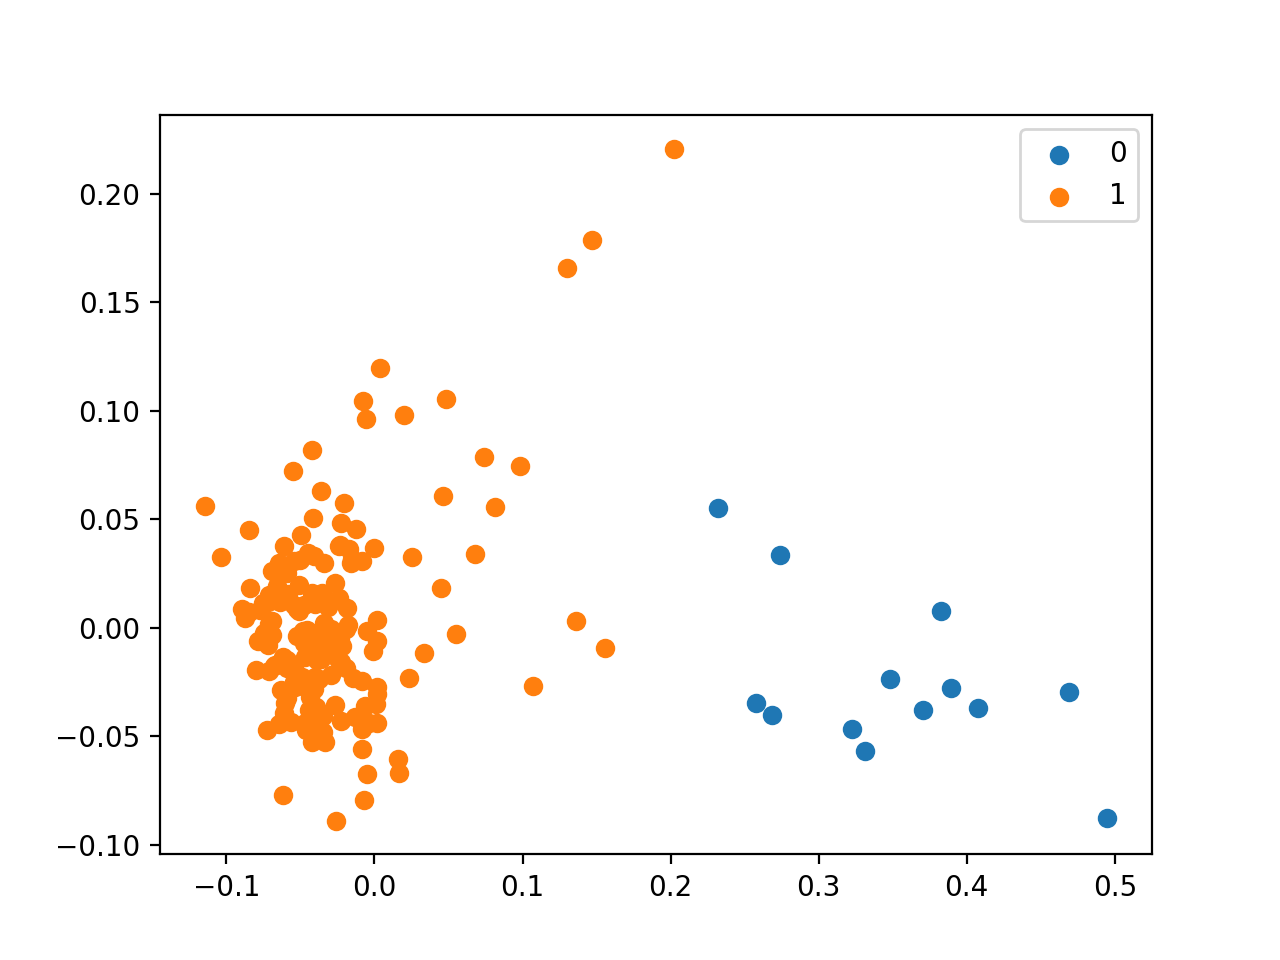

In [30]:
# visualize the embedding space
pca = PCA(2)
 
pca_transformed = pca.fit_transform(X)
X2 = pca_transformed

# plot the clusters with matplotlib
for i in np.unique(label):
    plt.scatter(X2[label == i , 0] , X2[label == i , 1] , label = i)
plt.legend()
plt.show()

In [17]:
df = pd.DataFrame(X2)
df.columns = ['pc1', 'pc2']
df['cluster'] = label
df['sam'] = sams
df

,pc1,pc2,cluster,sam
0,0.380309,-0.032754,0,TCGA-A2-A0CR-01A-11R-A22K-07
1,-0.071835,-0.002606,1,TCGA-A2-A0CS-01A-11R-A115-07
2,0.377124,0.002129,0,TCGA-A2-A0CQ-01A-21R-A034-07
3,-0.099885,-0.012556,1,TCGA-A1-A0SH-01A-11R-A084-07
4,-0.052723,0.011416,1,TCGA-A1-A0SI-01A-11R-A144-07
...,...,...,...,...
1100,-0.049649,0.018401,1,TCGA-PL-A8LX-01A-11R-A41B-07
1101,-0.031025,0.026678,1,TCGA-S3-AA15-01A-11R-A41B-07
1102,0.092787,0.155009,1,TCGA-S3-AA0Z-01A-11R-A41B-07
1103,-0.036763,0.010004,1,TCGA-S3-AA10-01A-21R-A41B-07


In [18]:
df.to_csv('../output/BRCA-spectral-clust.txt', sep="\t", index=False, quoting=False)

In [26]:
# add clinical data to overlay
meta = pd.read_csv('../examples/TCGA_metadata.csv')

meta = meta[['entity_submitter_id','sample_types', 'ajcc_pathologic_stage',
                          'tissue_or_organ_of_origin', 'days_to_last_follow_up', 'primary_diagnosis',
                          'year_of_diagnosis', 'vital_status', 'race', 'gender', 'ethnicity', 'age_at_index',
                          'site_of_resection_or_biopsy']]

#meta = pd.read_csv('../examples/tcga_brca_meta.txt', delimiter="\t")

/tmp/ipykernel_810474/1260312794.py:2: DtypeWarning: Columns (88,97,105,119,121,127) have mixed types. Specify dtype option on import or set low_memory=False.


In [29]:
df = df.merge(meta, left_on='sam', right_on='entity_submitter_id')
df

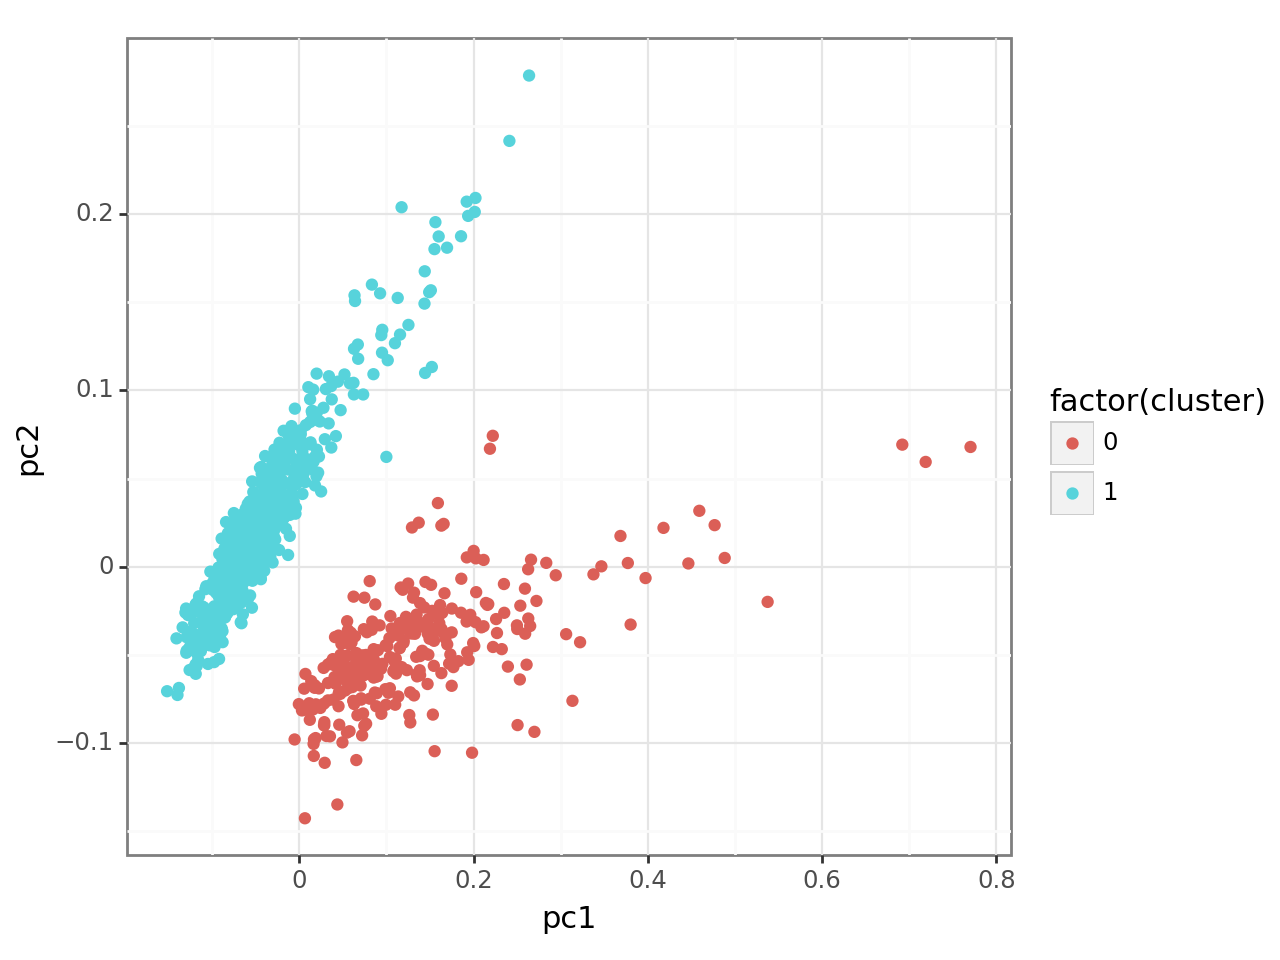

<Figure Size: (640 x 480)>

In [19]:
# examine clinical features
(ggplot(df, aes("pc1", "pc2", color="factor(cluster)"))
 + geom_point() + theme_bw()
 )

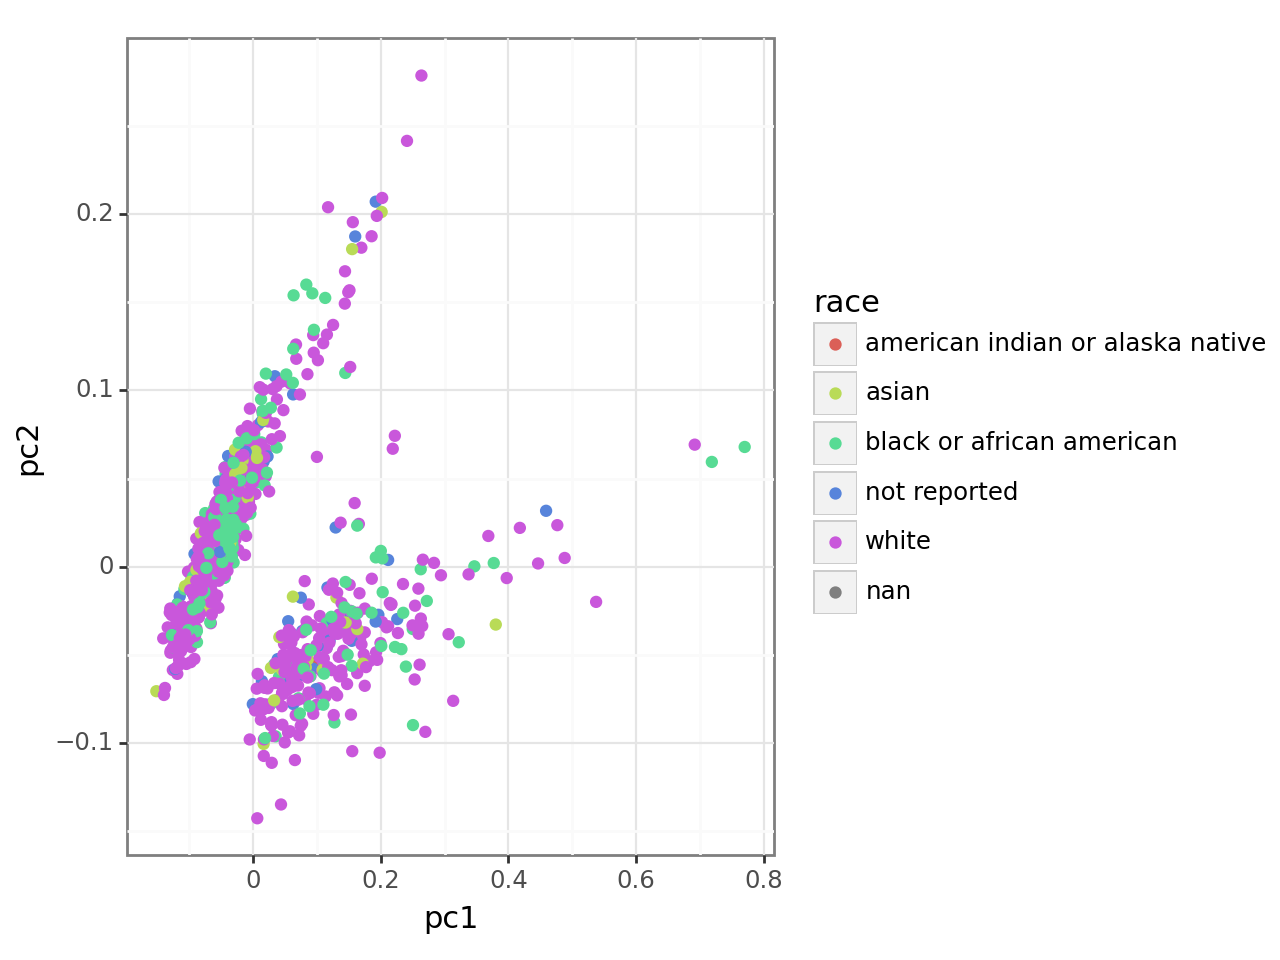

<Figure Size: (640 x 480)>

In [34]:
(ggplot(df, aes("pc1", "pc2", color="race"))
 + geom_point() + theme_bw() 
 )